In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import warnings
import json
warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd

combined_dfs = {}

# Define the base URL for the BIS Stats API
base_url = 'https://stats.bis.org/api/v1'

count_codes = [['AUDUSD.a','AU'], ['USDCAD.a', 'CA'],
               ['USDCHF.a','CH'], ['GBPUSD.a', 'GB'],
               ['USDJPY.a', 'JP'], ['NZDUSD.a', 'NZ'], 
               ['EURUSD.a', 'XM']]

for country in count_codes:

    # Define the endpoint parameters
    flow = 'BIS,WS_EER_D,1.0'  # Example: Version 1.0 of the WS_EER_M domain, maintained by the BIS
    key = f'D.N.N.{country[1]}'
    start_period = '2000'  # Example: Start year 2000
    end_period = '2023'  # Example: End year 2020
    detail = 'full'  # Example: All data and documentation

    # Construct the endpoint URL
    endpoint_url = f'{base_url}/data/{flow}/{key}/all'

    # Define the query parameters
    query_params = {
        'startPeriod': start_period,
        'endPeriod': end_period,
        'detail': detail
    }

    # Make the GET request
    response = requests.get(endpoint_url, params=query_params)

    # Check for a successful response
    if response.status_code == 200:
        # Assign the text of the response to xml_data
        xml_data = response.text

        # Parse the XML data
        root = ET.fromstring(xml_data)

        # Initialize empty lists to store the data
        time_periods = []
        obs_values = []

        # Iterate through the XML and extract the desired information
        for obs in root.findall(".//Obs"):
            time_period = obs.get('TIME_PERIOD')
            obs_value = obs.get('OBS_VALUE')
            time_periods.append(time_period)
            obs_values.append(obs_value)

        # Create a DataFrame
        df = pd.DataFrame({
            'Time_Period': time_periods,
            'OBS_Value': obs_values
        })

        df['OBS_Value'] = df['OBS_Value'].replace('NaN', np.nan)
        # Drop rows with NaN values
        df.dropna(subset=['OBS_Value'], inplace=True)
        df['OBS_Value'] = df['OBS_Value'].astype(float)
        df['Time_Period'] = pd.to_datetime(df['Time_Period'])
        
        df = df.set_index('Time_Period')
        print(f"Getting {country[0]}'s rates")
        rates = get_rates(country[0], mt5.TIMEFRAME_D1, 2500)
        
        combined = pd.concat([df[-len(rates):], rates['close']], join = 'outer', axis = 1)
        
        combined_dfs[country[1]] = combined.dropna()

    else:
        print(f'Failed to retrieve data: {response.status_code}')

Getting AUDUSD.a's rates
Getting USDCAD.a's rates
Getting USDCHF.a's rates
Getting GBPUSD.a's rates
Getting USDJPY.a's rates
Getting NZDUSD.a's rates
Getting EURUSD.a's rates


In [3]:
from statsmodels.tsa.stattools import grangercausalitytests

import contextlib
import io
import statsmodels.api as sm

granger_dict = {}  # Initialize an empty dictionary

for name, df in combined_dfs.items():

    print(f"---------------------------------Iterating through {name}---------------------------------")
    
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        grang_test = grangercausalitytests(df[['OBS_Value', 'close']], 10)
    
    # grang_test = grangercausalitytests(df[['OBS_Value', 'close']], 10)
    
    # Initialize an empty list to store significant lags for the current column
    significant_lags = []
    for i in range(1, 10):
        score = 0

        for test in grang_test[i][0]:
            p_val = grang_test[i][0][test][1]
            if p_val < 0.05:
                score += 1 
        if score == 4:
            print(f"Lag {i} is significant")
            # Append the significant lag to the list
            significant_lags.append(i)

    if significant_lags:
        granger_dict[name] = significant_lags

---------------------------------Iterating through AU---------------------------------
Lag 1 is significant
Lag 2 is significant
Lag 3 is significant
Lag 4 is significant
Lag 5 is significant
Lag 6 is significant
Lag 7 is significant
Lag 8 is significant
Lag 9 is significant
---------------------------------Iterating through CA---------------------------------
Lag 1 is significant
Lag 2 is significant
Lag 3 is significant
Lag 4 is significant
Lag 5 is significant
Lag 6 is significant
Lag 7 is significant
Lag 8 is significant
Lag 9 is significant
---------------------------------Iterating through CH---------------------------------
Lag 2 is significant
Lag 3 is significant
Lag 4 is significant
Lag 5 is significant
Lag 6 is significant
Lag 7 is significant
Lag 8 is significant
Lag 9 is significant
---------------------------------Iterating through GB---------------------------------
Lag 1 is significant
Lag 2 is significant
Lag 3 is significant
Lag 4 is significant
Lag 5 is significant
L

In [4]:
for key in combined_dfs.keys():
    print(f"Looping thru {key}")
    # Retrieve the corresponding lag value
    for lag in granger_dict['AU']:
        # lag = granger_dict[key]  # Assuming you want the first lag value from the list
        print(f"Shifting by {lag}")
        # Shift the 'OBS_Value' column in the DataFrame by the lag amount
        combined_dfs[key][f'Lag {lag} OBS_Value'] = combined_dfs[key]['OBS_Value'].shift(lag)

Looping thru AU
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru CA
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru CH
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru GB
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru JP
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru NZ
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9
Looping thru XM
Shifting by 1
Shifting by 2
Shifting by 3
Shifting by 4
Shifting by 5
Shifting by 6
Shifting by 7
Shifting by 8
Shifting by 9


In [5]:
for key in combined_dfs:
    combined_dfs[key].dropna(inplace=True)

In [6]:
# Calculate Weightings

eur_basket = ['EURUSD.a', 'EURJPY.a']
eur_w = 0.4
gbp_basket = ['GBPUSD.a', 'GBPCHF.a']
gbp_w = 0.4
misc_basket = ['AUDUSD.a', 'NZDUSD.a', 'USDCHF.a', 'USDCAD.a']
misc_w = 0.2

In [13]:
# Estimte Covariance Matrix

# Retrieve historical data for each currency pair
timeframe = mt5.TIMEFRAME_D1
x = 500

eur_data = {pair: get_rates(pair, timeframe, x) for pair in eur_basket}
gbp_data = {pair: get_rates(pair, timeframe, x) for pair in gbp_basket}
misc_data = {pair: get_rates(pair, timeframe, x) for pair in misc_basket}

# Combine the individual dictionaries into one
all_data_dict = {**eur_data, **gbp_data, **misc_data}

# Combine all data into a single DataFrame
all_data = pd.concat([all_data_dict[pair]['close'] for pair in all_pairs], axis=1)
all_data.columns = all_pairs

# Calculate daily returns
daily_returns = all_data.pct_change().dropna()

# Calculate the covariance matrix
cov_matrix = daily_returns.cov()

# Display the covariance matrix
cov_matrix

NameError: name 'all_pairs' is not defined

### Compute Expected Returns

Data to model:
- EER Values
- Bond Market 
- Simple ARIMA, GARCH model

Calculate an estimated return for each of the above models

In [12]:
import pandas as pd

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given data series.

    :param data: Pandas Series, price data.
    :param period: Integer, the number of periods to use for calculation (typically 14).
    :return: Pandas Series, RSI values.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.stats.diagnostic import acorr_ljungbox
import ta

def lin_features(name, data):
    # Rolling windows for moving averages
    fiften_day_avg = data.rolling(window=15).mean().round(5)
    sixty_day_avg = data.rolling(window=60).mean().round(5)
    
    # Volatility measures (e.g., rolling standard deviation)
    volatility = data.rolling(window=15).std().round(5)

    # Statistical moments: Skewness and Kurtosis
    skewness = data.rolling(window=15).apply(skew, raw=False).round(5)
    kurt = data.rolling(window=15).apply(kurtosis, raw=False).round(5)

    # Jump Detection (using Ljung-Box test on squared returns for large deviations)
    # Adjust the lags parameter as needed
    data_squared = np.square(data)
    lb_test_pvalues = data_squared.rolling(window=15).apply(lambda x: acorr_ljungbox(x, lags=[10], return_df=True)['lb_pvalue'].iloc[-1], raw=False)

    # Create DataFrame to store all features
    features_df = pd.DataFrame(index=data.index)
    n = 10  # Lag for momentum and ROC, adjust as needed
    features_df[f'{name}_momentum'] = data - data.shift(n)
    features_df[f'{name}_fiften_day_avg'] = fiften_day_avg
    features_df[f'{name}_sixty_day_avg'] = sixty_day_avg
    features_df[f'{name}_RSI'] = calculate_rsi(data, period=14)
    features_df[f'{name}_ROC'] = ((data - data.shift(n)) / data.shift(n)) * 100  # Expressed in percentage
    features_df[f'{name}_volatility'] = volatility
    features_df[f'{name}_skewness'] = skewness
    features_df[f'{name}_kurtosis'] = kurt
    features_df[f'{name}_jump_detection'] = lb_test_pvalues

    # Remove rows with any NA values
    features_df.dropna(inplace=True)
    
    return features_df

In [41]:
# Compute Expected Returns
weekly_dfs = {}
features = ['OBS_Value', 'close']

for name, dfs in combined_dfs.items():
    df = combined_dfs[name]
    # Assuming 'df' is your DataFrame
    df['date'] = pd.to_datetime(df.index)
    df.set_index('date', inplace=True)

    # Resample to get the last value of each week
    weekly = df.resample('W').last()
    weekly_dfs[name] = weekly

    
weekly_dfs_au = weekly_dfs['AU']

# # Create model to forecast close based on EER values
for i in features:
    new_features = lin_features(i, weekly_dfs_au[i])
    weekly_dfs_au = pd.concat([weekly_dfs_au, new_features], axis = 1, join = 'outer') 

In [42]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
features = weekly_dfs_au.columns
features = features.drop('close')
features

Index(['OBS_Value', 'Lag 1 OBS_Value', 'Lag 2 OBS_Value', 'Lag 3 OBS_Value',
       'Lag 4 OBS_Value', 'Lag 5 OBS_Value', 'Lag 6 OBS_Value',
       'Lag 7 OBS_Value', 'Lag 8 OBS_Value', 'Lag 9 OBS_Value',
       'OBS_Value_momentum', 'OBS_Value_fiften_day_avg',
       'OBS_Value_sixty_day_avg', 'OBS_Value_RSI', 'OBS_Value_ROC',
       'OBS_Value_volatility', 'OBS_Value_skewness', 'OBS_Value_kurtosis',
       'OBS_Value_jump_detection', 'close_momentum', 'close_fiften_day_avg',
       'close_sixty_day_avg', 'close_RSI', 'close_ROC', 'close_volatility',
       'close_skewness', 'close_kurtosis', 'close_jump_detection'],
      dtype='object')

In [54]:
y = weekly_dfs_au['close'].dropna()

percentage_change = y.pct_change().fillna(0)

def categorize_change(pct_change):
    if pct_change <= -0.02:
        return 0  # Strong Bearish
    elif pct_change <= -0.01:
        return 1  # Moderate Bearish
    elif pct_change < 0.01:
        return 2  # Moderate Bullish
    else:
        return 3  # Strong Bullish

y_categorical = percentage_change.apply(categorize_change)

In [66]:
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy

# Convert labels to one-hot encoded format
y_categorical_onehot = to_categorical(y_categorical)
y_categorical_onehot = y_categorical_onehot[-len(X):]

# Selecting the features and target variable
X = au_df[features].dropna()
y = au_df['close'].iloc[-len(X):]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy

# Splitting data into training and validation sets for classification
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_categorical_onehot, test_size=0.2, random_state=42)

# LSTM model for classification
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))  # 4 neurons for 4 classes

model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Fit model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    verbose=2, callbacks=[early_stopping])


IndexError: tuple index out of range

In [44]:
import numpy as np
import tensorflow as tf
import random as python_random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping

# Set a random seed for reproducibility
np.random.seed(123) 
python_random.seed(123)
tf.random.set_seed(1234)

# Assuming 'weekly_dfs_au' is your DataFrame and 'features' is your list of feature columns
au_df = weekly_dfs_au

# Selecting the features and target variable
X = au_df[features].dropna()
y = au_df['close'].iloc[-len(X):]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

# Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    verbose=2, callbacks=[early_stopping])

# Evaluate the model
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)

Epoch 1/100
11/11 - 8s - loss: 0.4838 - mean_squared_error: 0.4838 - val_loss: 0.4415 - val_mean_squared_error: 0.4415 - 8s/epoch - 685ms/step
Epoch 2/100
11/11 - 0s - loss: 0.3909 - mean_squared_error: 0.3909 - val_loss: 0.3408 - val_mean_squared_error: 0.3408 - 159ms/epoch - 14ms/step
Epoch 3/100
11/11 - 0s - loss: 0.2763 - mean_squared_error: 0.2763 - val_loss: 0.2102 - val_mean_squared_error: 0.2102 - 152ms/epoch - 14ms/step
Epoch 4/100
11/11 - 0s - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - 169ms/epoch - 15ms/step
Epoch 5/100
11/11 - 0s - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - 151ms/epoch - 14ms/step
Epoch 6/100
11/11 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - 173ms/epoch - 16ms/step
Epoch 7/100
11/11 - 0s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - 143ms/epoch

In [47]:
last_sample = X.iloc[-1].values.reshape((1, 1, -1)) # Reshape to [1, 1, number_of_features]

# Now use the reshaped sample for prediction
prediction = float(model.predict(last_sample))

1/1 [==============================] - 0s 49ms/step


In [48]:
prediction

0.6905910968780518

<AxesSubplot:xlabel='time'>

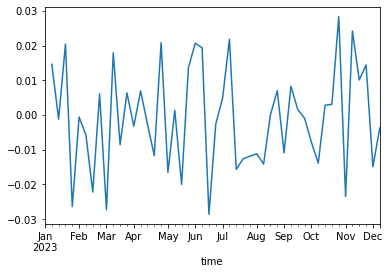

In [51]:
audusd_w = get_rates('AUDUSD.a', mt5.TIMEFRAME_W1, 50)
audusd_w['ret'] = audusd_w['close'].pct_change()
audusd_w['ret'].plot()

In [155]:
# Define investors views. SENTIMENT ANALYSIS


In [25]:
# Confidences in views
